In [107]:
import numpy as np
from scipy.integrate import solve_ivp
from SALib.sample import saltelli, sobol, fast_sampler
from SALib.analyze import sobol, fast
import seaborn as sns
import SALib
import matplotlib.pyplot as plt
import math
from scipy.optimize import fsolve
from scipy.constants import N_A

In [108]:
Target_cell_number = 2e5
well_size = 150e-6
r_ab = 1.25e-6 # in cm
t_end = 60*60*10
t = np.geomspace(1e-10, t_end, 20)
tspan = [1e-10, t_end]
z0 = [0, 0, 0]
z01 = [0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
reaction_volume = (2/3)*math.pi*((r_ab)**3)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [109]:
sigma = well_size*N_A/Target_cell_number

def A1_steady_state(x, Ainit, k1, koff, k2, rtot, dummy):
    k1 = k1/sigma
    Atot = sigma*Ainit
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot, dummy):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express



In [110]:

problem1 = {
    'num_vars': 5,
    'names': ['rtot', 'kon', 'D', 'koff', 'dummy'],
    'bounds': [[4, 6],
               [4, 6],
               [-15, -13],
               [-6, -4],
               [1, 1000]]
}

problem2 = {
    'num_vars': 4,
    'names': ['kon', 'k2', 'koff', 'dummy'],
    'bounds': [[1e3, 1e7],
               [1e4, 1e6],
               [1e-6, 1e-1],
               [1, 1000]]
}


vals = SALib.sample.sobol.sample(problem1, 65536)
Y_ag1 = np.zeros(len(vals))
Y_ag2 = np.zeros(len(vals))
Y_ab = np.zeros(len(vals))
indicies_ag1 = []
indicies_ag2 = []
indicies_ab = []
A0s = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
Y = np.zeros(len(vals))
indicies = []
indicies_1 = []

In [111]:
65536

65536

In [112]:
sol_holder = []
for Ainit in A0s:
    print(Ainit)
    for i, params in enumerate(vals):
     
        rtot = params[0]
        rtot  = 10**rtot
        kon = params[1]
        kon = 10**kon
        D = params[2]
        D = 10**D
        koff = params[3]
        koff = 10**koff
        dummy = params[4]

        k2 = 4*D/tumour_cell_surface_area

        guess = 0

        A1_st = fsolve(A1_steady_state, [guess], args=(Ainit, kon, koff, k2, rtot, dummy))
        A2_st = A2_steady_state(A1_st, k2, koff, rtot, dummy)
        if (A1_st < 0) or (A2_st < 0) :
            print('negative')
        
        if ((A1_st + 2*A2_st) > rtot):
            print('blown up')
        Ag =(A1_st + A2_st)
        Y[i] = Ag
    
    Si = sobol.analyze(problem1, Y, print_to_console=True)
    indicies.append(Si['ST'])
    indicies_1.append(Si['S1'])


1e-11
             ST   ST_conf
rtot   0.864731  0.073229
kon    0.340956  0.031241
D      0.340312  0.036978
koff   0.654081  0.061920
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.142300  0.022523
kon    0.019549  0.015667
D      0.013022  0.007245
koff   0.043792  0.013084
dummy  0.000000  0.000000
                     S2   S2_conf
(rtot, kon)    0.065165  0.047877
(rtot, D)      0.062094  0.041651
(rtot, koff)   0.236847  0.063019
(rtot, dummy) -0.010621  0.031486
(kon, D)       0.005365  0.021430
(kon, koff)    0.021129  0.024024
(kon, dummy)  -0.006299  0.017438
(D, koff)      0.024652  0.016049
(D, dummy)    -0.000496  0.011733
(koff, dummy) -0.002839  0.019964
1e-10
             ST   ST_conf
rtot   0.999915  0.008450
kon    0.000104  0.000007
D      0.000078  0.000006
koff   0.000175  0.000010
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.999766  0.009315
kon    0.000030  0.000099
D      0.000022  0.000105
koff   0.000051  0.000146
dummy  0.000000 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST       ST_conf
rtot   0.999989  7.954641e-03
kon    0.000013  4.942728e-07
D      0.000009  3.113450e-07
koff   0.000005  5.883427e-07
dummy  0.000000  0.000000e+00
             S1   S1_conf
rtot   0.999979  0.012532
kon    0.000007  0.000040
D      0.000005  0.000033
koff   0.000001  0.000022
dummy  0.000000  0.000000
                         S2   S2_conf
(rtot, kon)    6.584399e-06  0.017975
(rtot, D)      1.419275e-06  0.017969
(rtot, koff)   3.262159e-06  0.017968
(rtot, dummy)  3.000835e-06  0.017971
(kon, D)       5.600972e-06  0.000059
(kon, koff)    3.203253e-06  0.000059
(kon, dummy)   2.863986e-06  0.000059
(D, koff)      4.041574e-07  0.000045
(D, dummy)     5.734016e-08  0.000045
(koff, dummy)  8.209093e-06  0.000036
1e-08


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
rtot   9.998040e-01  7.285869e-03
kon    1.624730e-04  4.545331e-06
D      1.575513e-04  3.899126e-06
koff   1.040702e-07  5.174114e-09
dummy  0.000000e+00  0.000000e+00
                 S1   S1_conf
rtot   9.997224e-01  0.012333
kon    8.209873e-05  0.000130
D      7.987646e-05  0.000147
koff   1.193755e-07  0.000003
dummy  0.000000e+00  0.000000
                         S2   S2_conf
(rtot, kon)    3.482086e-05  0.020937
(rtot, D)      3.175083e-05  0.020928
(rtot, koff)  -1.298297e-07  0.020949
(rtot, dummy) -2.742903e-08  0.020949
(kon, D)       3.232655e-05  0.000214
(kon, koff)    1.034709e-06  0.000213
(kon, dummy)   1.018598e-06  0.000213
(D, koff)     -1.079706e-06  0.000209
(D, dummy)    -1.096830e-06  0.000209
(koff, dummy)  1.210475e-07  0.000005
1e-07


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
rtot   9.984206e-01  8.003188e-03
kon    1.387140e-03  4.015501e-05
D      1.383303e-03  3.790779e-05
koff   9.464208e-09  4.668623e-10
dummy  0.000000e+00  0.000000e+00
                 S1   S1_conf
rtot   9.975911e-01  0.012781
kon    6.759811e-04  0.000366
D      6.773857e-04  0.000419
koff   2.419413e-08  0.000001
dummy  0.000000e+00  0.000000
                         S2   S2_conf
(rtot, kon)    3.484588e-04  0.019522
(rtot, D)      3.421122e-04  0.019390
(rtot, koff)  -5.273142e-07  0.019492
(rtot, dummy) -4.959281e-07  0.019492
(kon, D)       2.292057e-04  0.000623
(kon, koff)    5.057228e-06  0.000619
(kon, dummy)   5.054839e-06  0.000619
(D, koff)     -2.410184e-06  0.000643
(D, dummy)    -2.414040e-06  0.000643
(koff, dummy)  4.423384e-08  0.000002
1e-06


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
rtot   9.917185e-01  8.318626e-03
kon    8.058557e-03  2.023204e-04
D      8.059856e-03  2.034905e-04
koff   8.222691e-10  4.822260e-11
dummy  0.000000e+00  0.000000e+00
                 S1       S1_conf
rtot   9.856027e-01  1.320574e-02
kon    3.715756e-03  9.580610e-04
D      3.734485e-03  1.025501e-03
koff   3.684816e-09  2.999077e-07
dummy  0.000000e+00  0.000000e+00
                         S2       S2_conf
(rtot, kon)    2.632975e-03  1.885183e-02
(rtot, D)      2.611059e-03  1.921120e-02
(rtot, koff)  -2.173442e-06  1.886625e-02
(rtot, dummy) -2.164743e-06  1.886622e-02
(kon, D)       8.542239e-04  1.495438e-03
(kon, koff)    2.152250e-05  1.458413e-03
(kon, dummy)   2.152090e-05  1.458404e-03
(D, koff)     -6.850345e-06  1.599460e-03
(D, dummy)    -6.853102e-06  1.599457e-03
(koff, dummy)  1.861971e-08  4.160500e-07
1e-05


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
rtot   9.803238e-01  1.049698e-02
kon    2.203234e-02  6.252244e-04
D      2.204622e-02  5.551612e-04
koff   5.800086e-11  2.976666e-12
dummy  0.000000e+00  0.000000e+00
                 S1       S1_conf
rtot   9.584303e-01  1.365926e-02
kon    9.434011e-03  1.679565e-03
D      9.495676e-03  1.759255e-03
koff  -1.312717e-09  7.983675e-08
dummy  0.000000e+00  0.000000e+00
                         S2       S2_conf
(rtot, kon)    1.013041e-02  1.821573e-02
(rtot, D)      1.007443e-02  1.864674e-02
(rtot, koff)  -5.985435e-06  1.831308e-02
(rtot, dummy) -5.983181e-06  1.831307e-02
(kon, D)       7.989960e-04  3.018289e-03
(kon, koff)    6.231619e-05  2.960568e-03
(kon, dummy)   6.231452e-05  2.960569e-03
(D, koff)     -7.668195e-06  3.102126e-03
(D, dummy)    -7.671166e-06  3.102126e-03
(koff, dummy)  8.434622e-09  1.280395e-07


7


/var/folders/fj/3c6fc0c93lg7p91tnylb8zj80000gn/T/ipykernel_33078/1119900174.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Dark2')


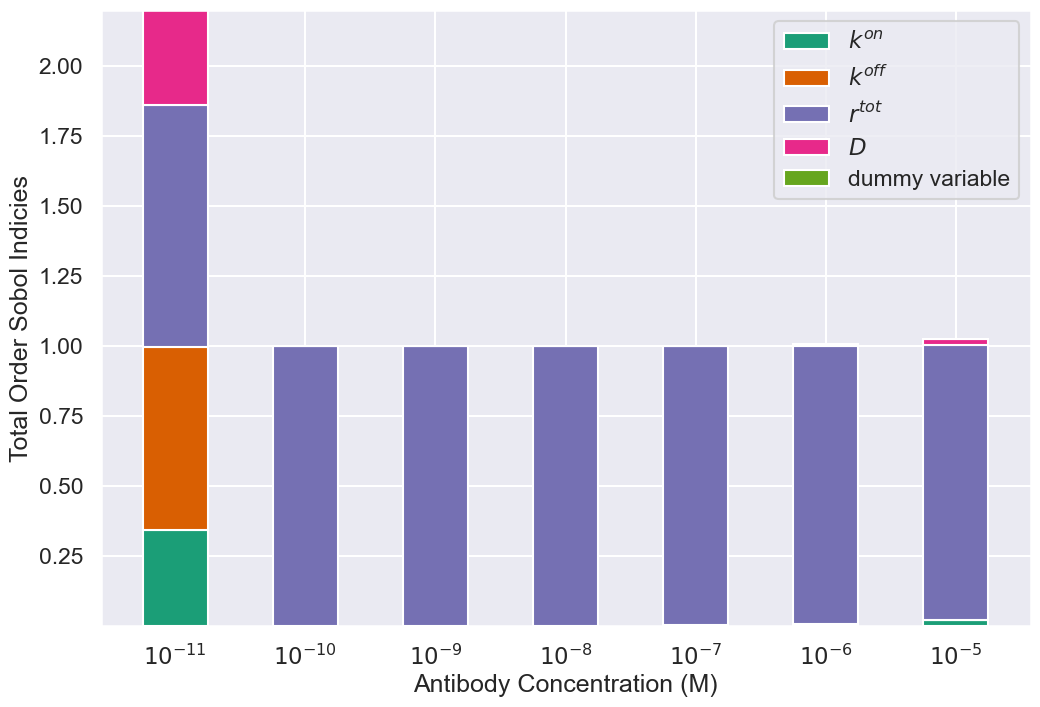

In [113]:

kon_si = np.zeros(len(A0s))
koff_si = np.zeros(len(A0s))
D_si = np.zeros(len(A0s))
rtot_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))


for i in range(len(indicies)):
    vals = indicies[i]
    rtot_si[i] = vals[0]
    kon_si[i] = vals[1]
    D_si[i] = vals[2]
    koff_si[i] = vals[3]
    dummy_si[i] = vals[4]

print(len(indicies))
ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')


sns.set_theme()
sns.set_context("talk")

width = 0.5
fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(7)

cm = plt.cm.get_cmap('Dark2')
ax.bar(ab_conc, kon_si, width, label=r'$k^{on}$', bottom= bottom, color=cm(0))
bottom+= kon_si
ax.bar(ab_conc, koff_si, width, label=r'$k^{off}$', bottom= bottom, color=cm(1))
bottom+= koff_si
ax.bar(ab_conc, rtot_si, width, label=r'$r^{tot}$', bottom= bottom, color=cm(2))
bottom+= rtot_si
ax.bar(ab_conc, D_si, width, label=r'$D$', bottom= bottom, color=cm(3))
bottom+= D_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color=cm(4))
ax.legend(loc='best')
ax.set_xlabel('Antibody Concentration (M)')
ax.set_ylabel('Total Order Sobol Indicies')
plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/model_s_bound_antibody_total_order_sensiv_analysis.png')

7


Text(0, 0.5, 'Total Order Sobol Indicies')

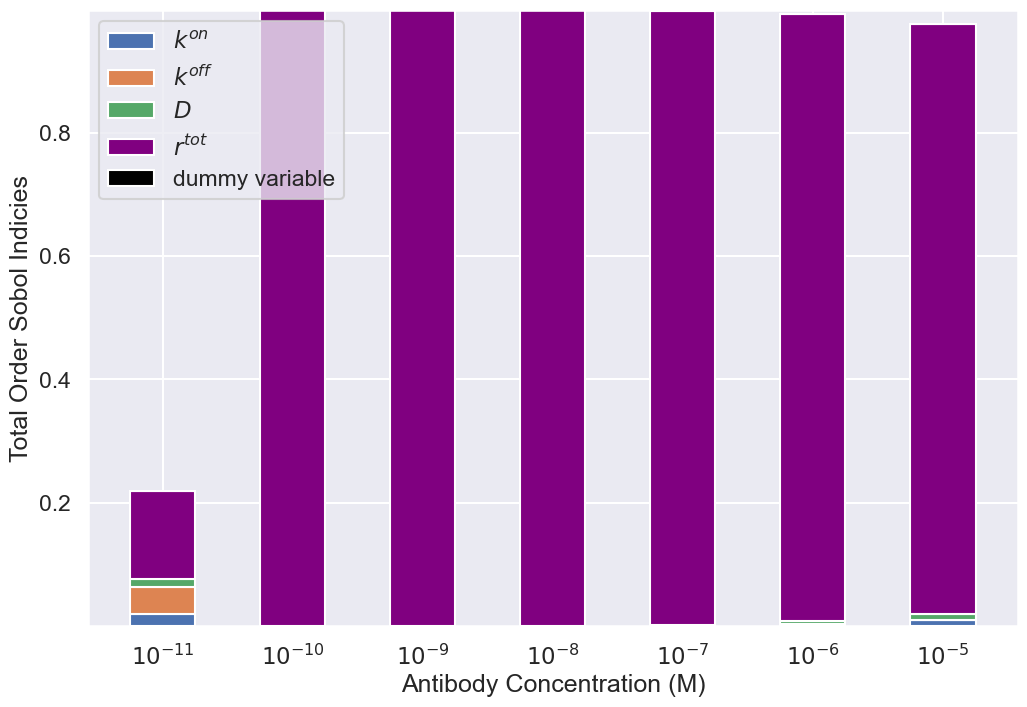

In [114]:
kon_si = np.zeros(len(A0s))
koff_si = np.zeros(len(A0s))
D_si = np.zeros(len(A0s))
rtot_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))

for i in range(len(indicies_1)):
    vals = indicies_1[i]
    rtot_si[i] = vals[0]
    kon_si[i] = vals[1]
    D_si[i] = vals[2]
    koff_si[i] = vals[3]
    dummy_si[i] = vals[4]

print(len(indicies_1))
ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')

param_indicies = {
    r"$k^{on}$": kon_si,
    r"$k^{off}$": koff_si,
    r"$D$": D_si,
    
}

sns.set_theme()
sns.set_context("talk")

width = 0.5
fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(7)

for boolean, param_indicie in param_indicies.items():
    p = ax.bar(ab_conc, param_indicie, width, label=boolean, bottom=bottom)
    bottom += param_indicie
ax.bar(ab_conc, rtot_si, width, label=r'$r^{tot}$', bottom= bottom, color='purple')
bottom+= rtot_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color='black')
ax.legend(loc='best')
ax.set_xlabel('Antibody Concentration (M)')
ax.set_ylabel('Total Order Sobol Indicies')
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/model_s_bispecific_total_ab_sensiv_analysis.png')